In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib nbagg

# Third party import
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import imread
import scipy.io
from tqdm import tqdm_notebook

# Package import
from modopt.math.metrics import ssim
from modopt.opt.linear import Identity
from modopt.opt.proximity import SparseThreshold, LinearCompositionProx, LinearCompositionIterativeProx
from mri.numerics.fourier import FFT2, NFFT
from mri.numerics.gradient import GradAnalysis2
from mri.numerics.linear import Wavelet2
from mri.numerics.reconstruct import sparse_rec_fista
from mri.numerics.utils import convert_mask_to_locations
import pysap
from pysap.data import get_sample_data


                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=0.18.0  - required | 1.2.1     installed
numpy          : >=1.11.0  - required | 1.16.2    installed
matplotlib     : >=2.0.0   - required | 3.0.3     installed
future         : >=0.16.0  - required | 0.17.1    installed
astropy        : ==2.0.8   - required | 2.0.8     installed
nibabel        : >=2.1.0   - required | 2.4.0     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
pywt           : >=1.0.0   - required | 1.0.2     installed
mri            : ==0.0.0   - requi

#  Loading input data

In [2]:
image = get_sample_data("mri-slice-nifti")
original_image_data = np.copy(image.data)
image.data += np.random.randn(*image.shape) * 20.
image.data = image.data.astype(np.complex128)
mask = get_sample_data("mri-mask")

In [3]:
non_cartesian = True
sparkling = True
opt_results = {}

# Generate the kspace 
From the 2D brain slice and the acquistion mask, we generate the acquisition measurments, the observed kspace. We then reconstruct the zero order solution.

In [4]:
# potential path to sparkling trajectory
sparkling_traj_file_path = '../personal_experiments/2019-Mar-01_N512_nc34_ns3073_OS1_decim64_decay2_tau0.75_nrevol1/samples_SPARKLING_N512_nc34x3073_OS1.mat'

In [5]:
# Generate the subsampled kspace
if non_cartesian:
    if sparkling:
        kspace_loc = scipy.io.loadmat(sparkling_traj_file_path)['samples']
    else:
        kspace_loc = convert_mask_to_locations(mask.data)
    fourier_op = NFFT(samples=kspace_loc, shape=image.shape)
    kspace_data = fourier_op.op(image.data)

    # Zero order solution
    image_rec0 = pysap.Image(data=fourier_op.adj_op(kspace_data), metadata=image.metadata)
else:
    kspace_mask = np.fft.ifftshift(mask.data)
    kspace_loc = convert_mask_to_locations(kspace_mask)
    fourier_op = FFT2(samples=kspace_loc, shape=image.shape)
    kspace_data = fourier_op.op(image.data)

    # Zero order solution
    image_rec0 = pysap.Image(data=fourier_op.adj_op(kspace_data), metadata=image.metadata)

/home/zaccharie/workspace/pysap-mri/mri/reconstruct/fourier.py:172: UserWarning: Samples will be normalized between [-0.5; 0.5[
  warnings.warn("Samples will be normalized between [-0.5; 0.5[")
/home/zaccharie/workspace/pysap-mri/mri/reconstruct/utils.py:103: UserWarning: Frequency equal to 0.5 will be put in -0.5
  warnings.warn("Frequency equal to 0.5 will be put in -0.5")


# Operators

In [6]:
nb_scales = 4
wavelet_name = 'db4'

In [7]:
linear_op = Wavelet2(
    nb_scale=nb_scales,
    wavelet_name=wavelet_name,
    padding='periodization',
)

gradient_op = GradAnalysis2(
    data=kspace_data,
    fourier_op=fourier_op)

# Define the proximity dual/primal operator
prox_op = LinearCompositionProx(
    linear_op=linear_op,
    prox_op=SparseThreshold(Identity(), None, thresh_type="soft"),
)
prox_op_iterative = LinearCompositionIterativeProx(
    linear_op=linear_op,
    prox_op=SparseThreshold(Identity(), None, thresh_type="soft"),
    max_precision_level=300,
    solver_sigma=10.0,
)
cost_op = None

# FAASTA optimization
We now want to refine the zero order solution using a FAASTA optimization.

In [8]:
def objective_cost(x):
    return data_fidelity(x) + sparsity(x)

def sparsity(x):
    return mu * np.sum(np.abs(linear_op.op(x)))

def data_fidelity(x):
    return 0.5 * np.linalg.norm(fourier_op.op(x) - kspace_data)**2

In [9]:
def nrmse(x):
    return np.linalg.norm(x - original_image_data) / np.mean(original_image_data)

In [10]:
metrics_ = {
    "cost": {"metric": objective_cost, "mapping": {"x_new": "x"}, "cst_kwargs": {}, "early_stopping": False},
    "nrmse": {"metric": nrmse, "mapping": {"x_new": "x"}, "cst_kwargs": {}, "early_stopping": False},
}

In [11]:
mu = 80.0

In [12]:
max_iter = 50
convergence_pot = max_iter >= 500

In [13]:
# Start the FISTA reconstruction
cost_op = None
x_final, transform, costs, metrics = sparse_rec_fista(
    gradient_op=gradient_op,
    linear_op=Identity(),
    prox_op=prox_op,
    cost_op=cost_op,
    xi_restart=0.96,
    s_greedy=1.1,
    mu=mu,
    restart_strategy='greedy',
    pov='analysis',
    max_nb_of_iter=max_iter,
    metrics=metrics_,
    metric_call_period=5,
    verbose=1,
)
image_rec = pysap.Image(data=np.abs(x_final))

x_final_iterative, transform, costs, metrics_iterative = sparse_rec_fista(
    gradient_op=gradient_op,
    linear_op=Identity(),
    prox_op=prox_op_iterative,
    cost_op=cost_op,
    xi_restart=0.96,
    s_greedy=1.1,
    mu=mu,
    restart_strategy='greedy',
    pov='analysis',
    iterative_prox=True,
    max_nb_of_iter=max_iter,
    metrics=metrics_,
    metric_call_period=5,
    verbose=1,
)
image_rec_iterative = pysap.Image(data=np.abs(x_final_iterative))


  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  80.0
 - lipschitz constant:  95.5108226527068
 - data:  (512, 512)
 - max iterations:  50
 - image variable shape:  (512, 512)
 - alpha variable shape:  (512, 512)
----------------------------------------
Starting optimization...


100% (50 of 50) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


 - converged:  False
Done.
Execution time:  92.08959  seconds
----------------------------------------

  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  80.0
 - lipschitz constant:  95.5108226527068
 - data:  (512, 512)
 - max iterations:  50
 - image variable shape:  (512, 512)
 - alpha variable shape:  (512, 512)
----------------------------------------
Starting optimization...


100% (1 of 1) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 50) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--WARNING: Making input data immutable.
100% (1 of 1) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  2% (1 of 50) |                         | Elapsed Time: 0:00:00 ETA:   0:00:19WARNING: Making input data immutable.
100% (1 of 1) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  4% (2 of 50) |#                        | Elapsed Time: 0:00:00 ETA:   0:00:18WARNING: Making input data immutable.
100% (2 of 2) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  6% (3 of 50) |#                        | Elapsed Time: 0:00:01 ETA:   0:00:18WARNING: Making input data immutable.
100% (2 of 2) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
  8% (4 of 50) |##                       | Elapsed Time: 0:00:01 ETA:   0:00:18WARNING: Making input data immutable.
100% (3 of 3) |

100% (21 of 21) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
 82% (41 of 50) |###################     | Elapsed Time: 0:00:40 ETA:   0:00:16WARNING: Making input data immutable.
100% (21 of 21) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
 84% (42 of 50) |####################    | Elapsed Time: 0:00:41 ETA:   0:00:14WARNING: Making input data immutable.
100% (22 of 22) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
 86% (43 of 50) |####################    | Elapsed Time: 0:00:43 ETA:   0:00:11WARNING: Making input data immutable.
100% (22 of 22) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
 88% (44 of 50) |#####################   | Elapsed Time: 0:00:45 ETA:   0:00:10WARNING: Making input data immutable.
100% (23 of 23) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
 90% (45 of 50) |#####################   | Elapsed Time: 0:00:47 ETA:   0:00:08WARNING: Making input data immutable.
100% (23 of 23)

 - converged:  False
Done.
Execution time:  173.00462900000002  seconds
----------------------------------------


<IPython.core.display.Javascript object>


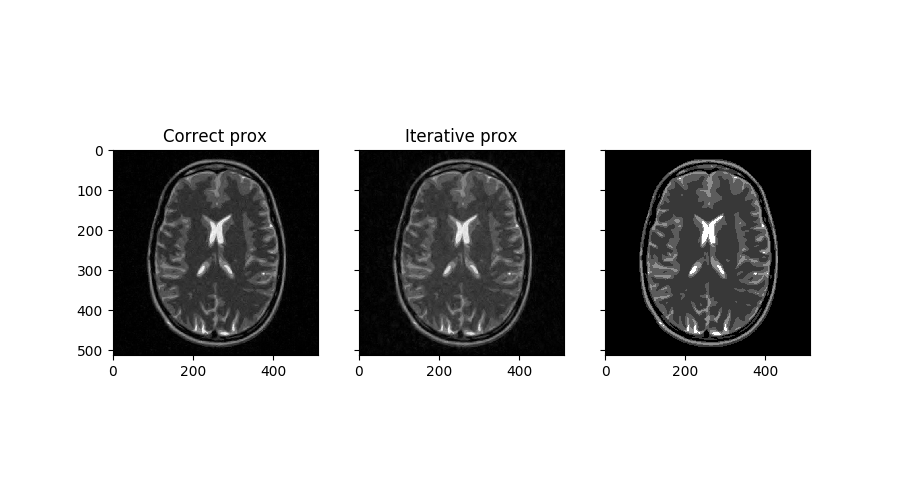

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(9, 5), sharex=True, sharey=True)
im0 = axs[0].imshow(np.abs(x_final), cmap='gray')
axs[0].set_title("Correct prox")
im1 = axs[1].imshow(np.abs(x_final_iterative), cmap='gray')
axs[1].set_title("Iterative prox")
axs[2].imshow(np.abs(original_image_data), cmap='gray')
# fig.colorbar(im0, ax=axs[0])
# fig.colorbar(im1, ax=axs[1])

<IPython.core.display.Javascript object>


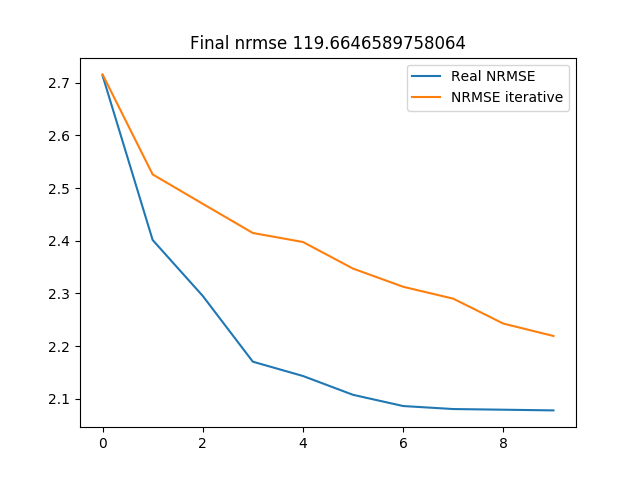

In [15]:
plt.figure()
plt.plot(np.log10(np.array(metrics['nrmse']['values'])), label='Real NRMSE')
plt.plot(np.log10(np.array(metrics_iterative['nrmse']['values'])), label='NRMSE iterative')
plt.title('Final nrmse {}'.format(metrics['nrmse']['values'][-1]))
plt.legend()

<IPython.core.display.Javascript object>


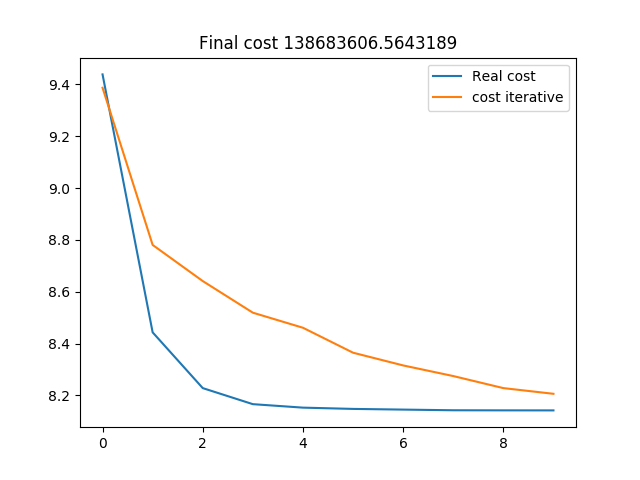

In [16]:
plt.figure()
plt.plot(np.log10(np.array(metrics['cost']['values'])), label='Real cost')
plt.plot(np.log10(np.array(metrics_iterative['cost']['values'])), label='cost iterative')
plt.title('Final cost {}'.format(metrics['cost']['values'][-1]))
plt.legend()